## Summarize

In [ ]:
!pip install sentencepiece
!pip install transformers
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 3.7 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization", model="t5-small")

In [ ]:
conversation = '''

Find
the following in tabular format as learned in class:
The
number of subnetworks
Sub-network
ID / Broadcast Address
Sub-netmask
First/Last
address that can be used for each subnet
1.
Given IP:         89.0.0.0


    Requirement:   1,300 Networks





2.
Given IP:         146.67.0.0


    Requirement:   845 Hosts/network
'''
# summarizer(conversation)[0]["summary_text"]
summarizer(conversation)

Your max_length is set to 200, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


[{'summary_text': 'the number of subnetworks Sub-network ID / Broadcast Address Subnetmask First/Last address that can be used for each subnet 1 . given IP: 89.0.0.0 Requirement: 1,300 Networks 2. Given IP:146.67.0.0 . . 845 Hosts/network .'}]

## Text to steps

### Import Tools

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Get a data

In [ ]:
df = pd.read_csv("v19.csv", on_bad_lines='warn', engine='python')

df.head()

,input,output
0,#,invalid
1,#,invalid
2,#,invalid
3,#,invalid
4,#,invalid


In [ ]:
df.shape

(20, 2)

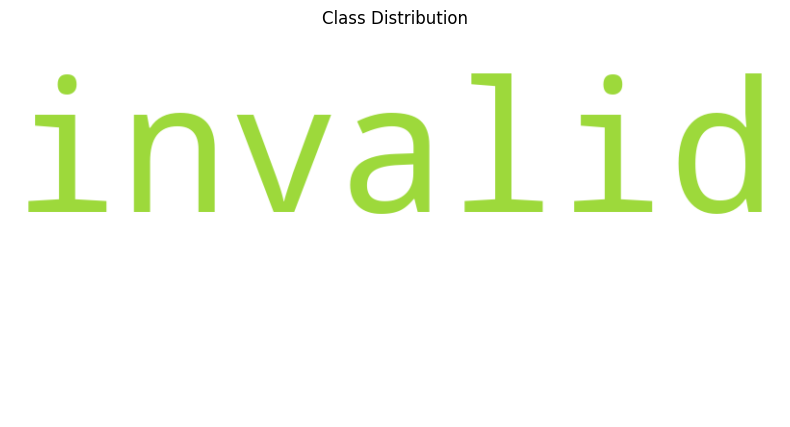

In [ ]:
class_distribution = df['output'].value_counts()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(class_distribution)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Class Distribution')
plt.show()


### Preprocessing

In [ ]:
from torch.utils.data import random_split

In [ ]:
np.random.seed(224)
# device = 'mps' if torch.backends.mps.is_available() else 'cpu'
# device
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device
device = 'cpu'
device

'cpu'

In [ ]:
MODEL_NAME = 't5-small'
BATCH_SIZE = 2
EPOCHS = 4
LEARNING_RATE = 2e-4

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_length=1024):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        source, target = self.data.iloc[index]
        source_enc = self.tokenizer(source, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt").to(device)
        target_enc = self.tokenizer(target, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt").to(device)
        return {
            "input_ids": source_enc["input_ids"].squeeze(),
            "attention_mask": source_enc["attention_mask"].squeeze(),
            "labels": target_enc["input_ids"].squeeze()
        }


In [ ]:
full_dataset = CustomDataset(df, tokenizer)
train_len = int(0.8 * len(full_dataset))
valid_len = len(full_dataset) - train_len
train_dataset, valid_dataset = random_split(full_dataset, [train_len, valid_len])



### Get a model

In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=100,
    learning_rate=LEARNING_RATE,
    output_dir='T5results',
    evaluation_strategy="steps",
    save_total_limit=2,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)]
)
trainer.train()

Step,Training Loss,Validation Loss
10,0.017300,0.006805
20,0.006600,0.001742
30,0.002800,0.000555


TrainOutput(global_step=32, training_loss=0.008580541296396405, metrics={'train_runtime': 16.6565, 'train_samples_per_second': 3.842, 'train_steps_per_second': 1.921, 'total_flos': 17323750588416.0, 'train_loss': 0.008580541296396405, 'epoch': 4.0})

### Evaluate

In [ ]:
def infer(input_text, model, tokenizer):
    model.eval()

    # Encode the input text
    input_tensor = tokenizer.encode(input_text, return_tensors="pt").to('cpu')

    # Generate output
    with torch.no_grad():
        output = model.generate(input_tensor, max_length=1024)
    # Decode and clean up the output
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

    # Post-process the output (if needed)
    decoded_output = decoded_output.replace(" and ", ", ").strip()

    return decoded_output



In [ ]:
sample_text = """
Beginning this week, each week your project team should do this:

1. Meet with a TA, either online or in person
    Work Product:  TA's notes on feedback and suggestions made to your team
2. Retrospective on process and progress
    Work Product:  In your project wiki create a file named "Retrospectives".
    for each week append a section to this file.  Include the date of the retrospective and who attended.
    - write a summary of the retrospective discussion
    - write a list of process improvement steps that you will implement in the next iteration.
      These should be concrete, actionable changes you will make in your software process.
      They can be small things, but should be written in a way that an observer can tell whether
       you did them or not, and the result is observable.

TAs will post a document containing their available times. You should sign up for a meeting.
You do not need to meet same TA each week. Meeting different TAs gives you a chance to
get different perspectives and ideas.
"""

print(infer(sample_text, model.to('cpu'), tokenizer))

### Save model

In [ ]:
model.save_pretrained("/content/drive/MyDrive/PlanMeNLP/custom_t5_modelv19")

## Load Model

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
model = T5ForConditionalGeneration.from_pretrained("/content/drive/MyDrive/PlanMeNLP/custom_t5_modelv18").to('cpu')
# model = T5ForConditionalGeneration.from_pretrained("Jwizzed/TaskToSubtask").to('cpu')
tokenizer = T5Tokenizer.from_pretrained("t5-small")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
